<a href="https://colab.research.google.com/github/rybak97/SR_cartoon/blob/main/FSRCNN_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Conv2DTranspose, Activation

from scipy import signal
from scipy import ndimage

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os
from PIL import Image

1. Network

In [2]:
_inputs  = Input(shape=(128, 128, 3), name='input')
C1 = Conv2D(56,(5,5),padding='same', activation='relu')(_inputs)
C2 = Conv2D(12,(1,1),padding='same', activation='relu')(C1)
C3 = Conv2D(12,(3,3),padding='same', activation='relu')(C2)
C4 = Conv2D(12,(3,3),padding='same', activation='relu')(C3)
C5 = Conv2D(12,(3,3),padding='same', activation='relu')(C4)
C6 = Conv2D(12,(3,3),padding='same', activation='relu')(C5)
C7 = Conv2D(56,(1,1), padding='same', activation='relu')(C6)
D1 = Conv2DTranspose(3,(9,9), strides=(1,1),padding='same', activation='relu')(C7)
model = keras.Model(inputs=_inputs, outputs=D1)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 56)      4256      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 12)      684       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 12)      1308      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 12)      1308      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 12)      1308      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 12)      1308  

2. Preparing data

In [3]:
ishape = 128

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_image = train_images[0:5000]
test_image  = test_images[0:500]


X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.

170508288/170498071 [==============================] - 4s 0us/step


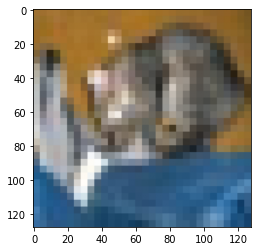

In [4]:
plt.imshow(X_test[0])

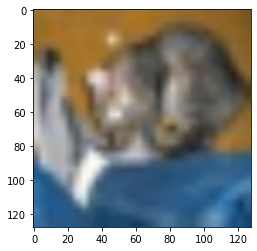

In [5]:
plt.imshow(y_test[0])

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model.save('FSRCNN.h5')
model.save_weights('model_weights.h5')

Epoch 1/3
63/63 [==============================] - 38s 370ms/step - loss: 0.7076 - mae: 0.1971 - val_loss: 0.0092 - val_mae: 0.0663
Epoch 2/3
63/63 [==============================] - 20s 317ms/step - loss: 0.0154 - mae: 0.0869 - val_loss: 0.0107 - val_mae: 0.0793
Epoch 3/3
63/63 [==============================] - 20s 317ms/step - loss: 0.0084 - mae: 0.0649 - val_loss: 0.0068 - val_mae: 0.0576
16/16 - 1s - loss: 0.0070 - mae: 0.0585 - 1s/epoch - 87ms/step
Test loss: 0.007020394783467054
Test mae: 0.058514051139354706


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


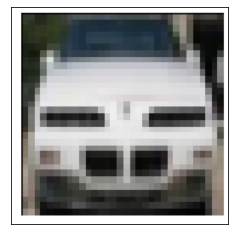

In [8]:
ishape = 128

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


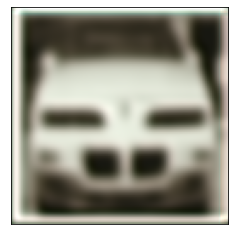

In [9]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.


img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [10]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([16.754797], shape=(1,), dtype=float32)


In [11]:
img = tf.reshape(img, [128,128,3,1])

img_SR = tf.reshape(img_SR, [128,128,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.38688216


3. Pokemon dataset

In [46]:
_inputs  = Input(shape=(120, 120, 3), name='input')
C1 = Conv2D(56,(5,5),padding='same', activation='relu')(_inputs)
C2 = Conv2D(12,(1,1),padding='same', activation='relu')(C1)
C3 = Conv2D(12,(3,3),padding='same', activation='relu')(C2)
C4 = Conv2D(12,(3,3),padding='same', activation='relu')(C3)
C5 = Conv2D(12,(3,3),padding='same', activation='relu')(C4)
C6 = Conv2D(12,(3,3),padding='same', activation='relu')(C5)
C7 = Conv2D(56,(1,1), padding='same', activation='relu')(C6)
D1 = Conv2DTranspose(3,(9,9), strides=(1,1),padding='same', activation='relu')(C7)
model2 = keras.Model(inputs=_inputs, outputs=D1)
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_35 (Conv2D)          (None, 120, 120, 56)      4256      
                                                                 
 conv2d_36 (Conv2D)          (None, 120, 120, 12)      684       
                                                                 
 conv2d_37 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_38 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_39 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_40 (Conv2D)          (None, 120, 120, 12)      1308

In [47]:
images = []


for file in os.listdir('/content/drive/MyDrive/images/'):
    images.append(cv.imread('/content/drive/MyDrive/images/{}'.format(file)))

In [48]:
ishape = 120

for a in range(len(images)):
  images[a] = cv.cvtColor(images[a], cv.COLOR_BGR2RGB)



train_image = images[0:647]
test_image  = images[647:]

train_image2 = images[0:647] #czyste
test_image2  = images[647:]



for i in range(np.asarray(647)):

  
  train_image[i] = cv.blur(train_image[i],(7,7))
   


for i in range(np.asarray(809-647)):

  
  test_image[i] = cv.blur(test_image[i],(7,7))
 

X_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.


y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image2]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image2]) / 255.

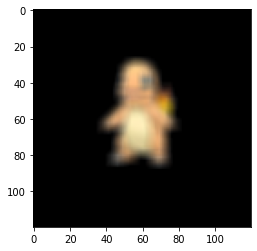

In [49]:
plt.imshow(X_test[77])

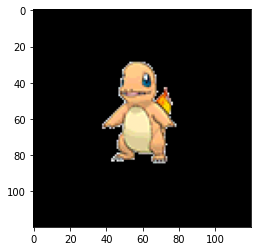

In [50]:
plt.imshow(y_test[77])

In [51]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.2)

test_scores = model2.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model2.save('FSRCNN_2.h5')

Epoch 1/30
17/17 [==============================] - 4s 156ms/step - loss: 2.7822 - mae: 0.4213 - val_loss: 0.0248 - val_mae: 0.0960
Epoch 2/30
17/17 [==============================] - 2s 138ms/step - loss: 0.0258 - mae: 0.0776 - val_loss: 0.0160 - val_mae: 0.0633
Epoch 3/30
17/17 [==============================] - 2s 139ms/step - loss: 0.0145 - mae: 0.0515 - val_loss: 0.0155 - val_mae: 0.0555
Epoch 4/30
17/17 [==============================] - 2s 138ms/step - loss: 0.0125 - mae: 0.0454 - val_loss: 0.0108 - val_mae: 0.0411
Epoch 5/30
17/17 [==============================] - 2s 138ms/step - loss: 0.0115 - mae: 0.0433 - val_loss: 0.0134 - val_mae: 0.0442
Epoch 6/30
17/17 [==============================] - 2s 138ms/step - loss: 0.0115 - mae: 0.0423 - val_loss: 0.0109 - val_mae: 0.0425
Epoch 7/30
17/17 [==============================] - 2s 137ms/step - loss: 0.0104 - mae: 0.0393 - val_loss: 0.0106 - val_mae: 0.0416
Epoch 8/30
17/17 [==============================] - 2s 137ms/step - loss: 0.

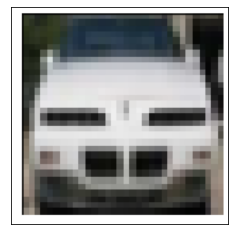

In [52]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


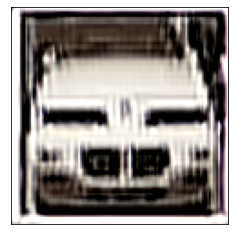

In [53]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [54]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([13.365607], shape=(1,), dtype=float32)


In [55]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.18951964


4. Pokemon dataset, but weights from model_1

In [56]:
_inputs  = Input(shape=(120, 120, 3), name='input')
C1 = Conv2D(56,(5,5),padding='same', activation='relu')(_inputs)
C2 = Conv2D(12,(1,1),padding='same', activation='relu')(C1)
C3 = Conv2D(12,(3,3),padding='same', activation='relu')(C2)
C4 = Conv2D(12,(3,3),padding='same', activation='relu')(C3)
C5 = Conv2D(12,(3,3),padding='same', activation='relu')(C4)
C6 = Conv2D(12,(3,3),padding='same', activation='relu')(C5)
C7 = Conv2D(56,(1,1), padding='same', activation='relu')(C6)
D1 = Conv2DTranspose(3,(9,9), strides=(1,1),padding='same', activation='relu')(C7)
model3 = keras.Model(inputs=_inputs, outputs=D1)
model3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_42 (Conv2D)          (None, 120, 120, 56)      4256      
                                                                 
 conv2d_43 (Conv2D)          (None, 120, 120, 12)      684       
                                                                 
 conv2d_44 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_45 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_46 (Conv2D)          (None, 120, 120, 12)      1308      
                                                                 
 conv2d_47 (Conv2D)          (None, 120, 120, 12)      1308

In [57]:
model3.load_weights('model_weights.h5')  

In [58]:
model3.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='mse',       
              metrics=['mae'])    

history = model3.fit(X_train, y_train,
                    batch_size=32,
                    epochs=1,
                    validation_split=0.2)

test_scores = model3.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model3.save('FSRCNN_3.h5')

17/17 [==============================] - 3s 149ms/step - loss: 0.0163 - mae: 0.0957 - val_loss: 0.0149 - val_mae: 0.0870
6/6 - 0s - loss: 0.0143 - mae: 0.0859 - 273ms/epoch - 46ms/step
Test loss: 0.01433548703789711
Test mae: 0.08586004376411438


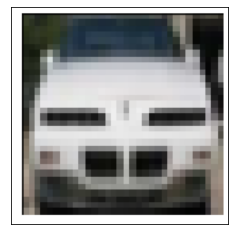

In [59]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


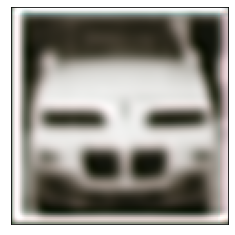

In [60]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model3.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

In [61]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([16.832754], shape=(1,), dtype=float32)


In [62]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.50351965
